# Fitting empirical data using Gaussian Mixture Models

In this notebook we aim at studying the problem of estimating the underling probability distribution of a phenomenon given empirical observations. More precisely, given IID random variables $X_i \sim P_X$ with observations $\{x_1, ..., x_n\}$, we want to estimate from the observations: How many modes has $P$? If we approximate $P$ by a combination of Gaussian distributions, how many distributions we actually need to fit the data? Which are the optimal parameters of these Gaussian distributions? 

Refs:
* https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
* add the ref to the book

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
import scipy.stats as stats
import math

### Create a toy example 

In [52]:
# === Set distribution parameters === #
k = 4  # number of Gaussians
sigma_0 = 1  # Set an order of magnitudo for the standard deviation
sigmas = sigma_0*np.random.random((k,))  # The std of each of the modes 
dist = .9*sigma_0 # min distance between the gaussians
means = -dist + np.cumsum(dist + dist*np.random.random((k,)))  # The mean of each gaussian will have a distance in [dist, 2*dist]
priors = np.random.random((k,))+1
priors /= priors.sum()  # normalized prior of each Gaussian

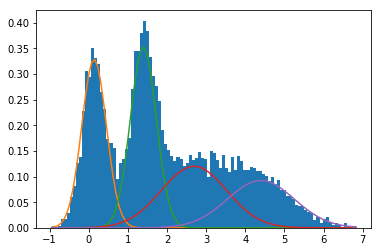

In [53]:
# === Sample empirical observations from P === # 
N = 10000  # approx number of observations
Ns = (N*priors).astype('int')
x = np.array([])
for i in range(k):
    new_x = np.random.normal(loc=means[i],scale=sigmas[i],size=(Ns[i],))
    x = np.append(x,new_x)

# Shuffle the data, 
np.random.shuffle(x)

if 1:
    plt.figure()
    plt.hist(x,bins=100, density=True)
    xx = np.linspace(x.min(), x.max(), 100)
    for i in range(k):
        plt.plot(xx, priors[i]*stats.norm.pdf(xx, means[i], sigmas[i]))

### Estimate the distributions using the data

In [54]:
# Split the data into 80% for fitting and 20% for testing
n = len(x)
x_fit = x[:int(.8*n)].reshape(-1,1)
x_eval = x[int(.8*n):].reshape(-1,1)

# ==== Set fitting parameters,  ===== #
k_e = k-0  # Set the number of gaussians 
# ----------------------------------- #

# Use "fit" partition to estimate the distribution of the data and evaluate the estimation on eval. 
gm = mixture.GaussianMixture(n_components=k_e, tol=0.001, reg_covar=1e-10, max_iter=100, 
                             n_init=30, init_params='kmeans', verbose=0, verbose_interval=10)

In [55]:
gm.fit(x_fit)
print('Score on fit/eval data: {}/{}'.format(gm.score(x_fit), gm.score(x_eval)))

Score on fit/eval data: -1.732719728072203/-1.745245615402051


In [56]:
a = gm.get_params(deep=True)

In [57]:
priors_est = gm.weights_.squeeze()
means_est = gm.means_.squeeze()
sigmas_est = np.sqrt(gm.covariances_.squeeze())  # var --> std

# Order the predictions to match the ground truth 
# (the order is arbitrary)
ind = np.argsort(means_est)
means_est = means_est[ind]
priors_est = priors_est[ind]
sigmas_est = sigmas_est[ind]

print('Priors Ground truth / estimated\n {}/{}'.format(priors, priors_est))
print('Means Ground truth / estimated\n {}/{}'.format(means, means_est))
print('Std Ground truth / estimated\n {}/{}'.format(sigmas, sigmas_est))

Priors Ground truth / estimated
 [0.25913908 0.29201334 0.2512486  0.19759898]/[0.25424082 0.36089312 0.22083715 0.16402891]
Means Ground truth / estimated
 [0.13614176 1.39445436 2.68801769 4.39794235]/[0.14744201 1.45020724 3.02244849 4.58358527]
Std Ground truth / estimated
 [0.3147082  0.32993854 0.83512055 0.85471952]/[0.31109867 0.39174554 0.6203375  0.71449991]


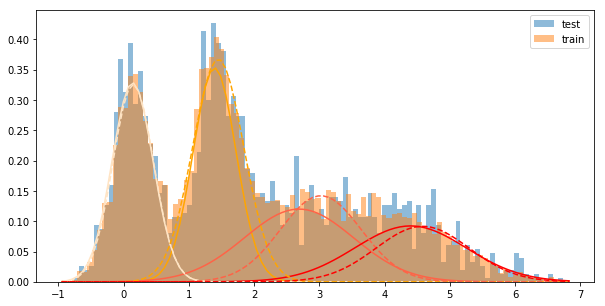

In [58]:
if 1:
    plt.figure(figsize=[10,5])
    plt.hist(x_eval,bins=100, density=True, alpha = .5)    
    plt.hist(x_fit,bins=100, density=True, alpha = .5)
    plt.legend(['test', 'train'])
    
    xx = np.linspace(x.min(), x.max(), 100)
    colors = ['bisque','orange','tomato','red']
    for i in range(k):
        plt.plot(xx, priors[i]*stats.norm.pdf(xx, means[i], sigmas[i]), color=colors[i])
    for i in range(k_e):
        plt.plot(xx, priors_est[i]*stats.norm.pdf(xx, means_est[i], sigmas_est[i]), '--', color=colors[i])

The result is not increadible accurate. (And we assumed we know the number of modes!.) An alternative approach to asses the modality and segment the regions associated to each mode is presented in:
https://github.com/BenjaminDoran/unidip

In [ ]:
# install this before importing using pip install 
# pop instrall unidip
from unidip import UniDip

# create bi-modal distribution
# dat = np.concatenate([np.random.randn(200)-3, np.random.randn(200)+3])
dat = x_fit.squeeze()

# sort data so returned indices are meaningful
dat = np.msort(dat)

# get start and stop indices of peaks 
intervals = UniDip(dat, alpha=0.03, ntrials=300, debug=0).run()

# Get the x coordinates of each interval
intervals_x = []
for i in intervals:
    intervals_x.append((dat[i[0]],dat[i[1]])) 

print(intervals)

In [ ]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

if 1:
    plt.figure(figsize=[10,5])
    plt.hist(x_eval,bins=100, density=True, alpha = .5)    
    plt.hist(x_fit,bins=100, density=True, alpha = .5)
    plt.legend(['test', 'train'])   
    xx = np.linspace(x.min(), x.max(), 100)
    colors = ['bisque','orange','tomato','red']
    for i in range(k):
        plt.plot(xx, priors[i]*stats.norm.pdf(xx, means[i], sigmas[i]), color=colors[i])
    boxes = []
    for ii in intervals_x:
        rec = Rectangle((ii[0], 0), ii[1]-ii[0], .5)
        boxes.append(rec)
                             
    pc = PatchCollection(boxes, facecolor='y', alpha=.5, edgecolor='b')
    # Add collection to axes
    ax = plt.gca()
    ax.add_collection(pc)

In [128]:
print(intervals_x)

[(-0.08376049996813306, 0.32994851846094575), (0.3365144406648065, 0.623789058684501), (0.9365972311875294, 1.8133877362440778)]
